# Product Recommendations with Document Similarity

Recommender systems are one of the popular and most adopted applications of machine learning. They are typically used to recommend entities to users and these entites can be anything like products, movies, services and so on.

Popular examples of recommendations include,

 - Amazon suggesting products on its website
 - Amazon Prime, Netflix, Hotstar recommending movies\shows
 - YouTube recommending videos to watch

Typically recommender systems can be implemented in three ways:

 - Simple Rule-based Recommenders: Typically based on specific global metrics and thresholds like movie popularity, global ratings etc.
 - Content-based Recommenders: This is based on providing similar entities based on a specific entity of interest. Content metadata can be used here like movie descriptions, genre, cast, director and so on
 - Collaborative filtering Recommenders: Here we don't need metadata but we try to predict recommendations and ratings based on past ratings of different users and specific items.

We will be building a product recommendation system here where based on data\metadata pertaining to different products, we try and recommend similar products of interest!

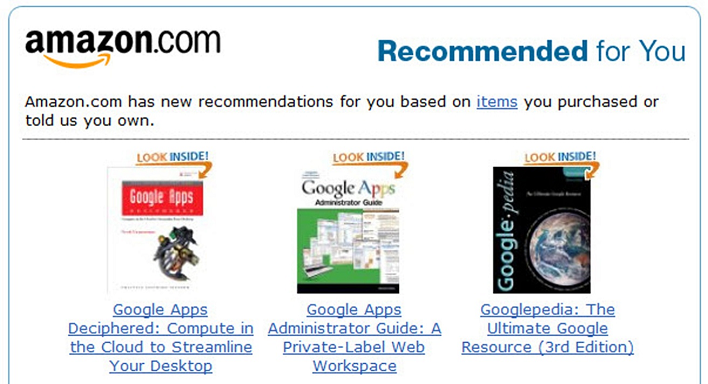

In [13]:
Image('/Users/amy/00_Springboard/14_Capstone_Project_2/amazon.png')

Since our focus in not really recommendation engines but NLP, we will be leveraging the text-based metadata for each product to try and recommend similar products based on specific products of interest. This falls under content-based recommenders.

## Import Necessary Libraries

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from  sklearn.metrics import precision_recall_fscore_support
import gensim
import nltk
from gensim.models.word2vec import Word2Vec
from nltk import word_tokenize
import tensorflow as tf
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
nltk.download('stopwords')
import re
import matplotlib.pyplot as plt

Using TensorFlow backend.
[nltk_data] Downloading package stopwords to /Users/amy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load and View Dataset

In [16]:
df = pd.read_csv('cleaned_text_school_supplies.csv')

In [17]:
df.isnull().sum()

customer_ID        0
product_ID         0
rating             0
review_text        0
rating_class       0
date_time          0
normalized_text    1
tokens             0
dtype: int64

In [18]:
df = df.dropna(axis=0)

In [19]:
df.head(2)

,customer_ID,product_ID,rating,review_text,rating_class,date_time,normalized_text,tokens
0,0136039847,A2MVR1VMDPMNGS,1.0,I honestly believe that giving this merchant o...,bad,2014-03-03,honestly believe give merchant one star favor ...,"['honestly', 'believe', 'give', 'merchant', 'o..."
1,0439504422,ASTJ36CFZRN3O,5.0,This is a standard size folder that fits stand...,good,2012-09-18,standard size folder fit standard paper 5x11 f...,"['standard', 'size', 'folder', 'fit', 'standar..."


# Build a Product Recommender System

## Document Similarity

Recommendations are about understanding the underlying features which make us favour one choice over the other. Similarity between items(in this case movies) is one way to understanding why we choose one movie over another. There are different ways to calculate similarity between two items. One of the most widely used measures is **cosine similarity** which we have already used in the previous unit.

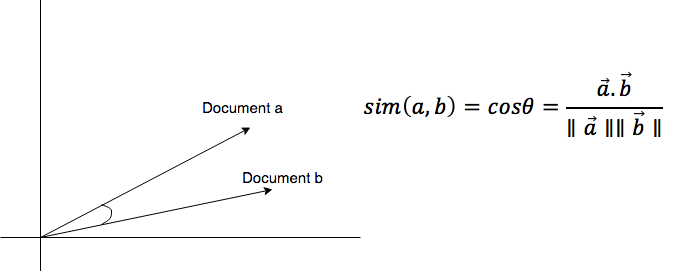

In [20]:
Image('/Users/amy/00_Springboard/14_Capstone_Project_2/cosine.png')

**Cosine Similarity** is used to calculate a numeric score to denote the similarity between two text documents. Mathematically, it is defined as above.

In [21]:
text_reviews = df['normalized_text'].values

In [22]:
len(text_reviews)

10835

## Extract TF-IDF Features

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
tfidf_matrix = tf.fit_transform(text_reviews)
tfidf_matrix.shape

(10835, 46723)

## Compute Pairwise Document Similarity

In [24]:
from sklearn.metrics.pairwise import cosine_similarity

doc_sim = cosine_similarity(tfidf_matrix)
doc_sim_df = pd.DataFrame(doc_sim)
doc_sim_df.head()

,0,1,2,3,4,5,6,7,8,9,...,10825,10826,10827,10828,10829,10830,10831,10832,10833,10834
0,1.000000,0.000000,0.005960,0.021123,0.011896,0.020562,0.023378,0.005625,0.004664,0.020495,...,0.000000,0.013248,0.019645,0.009819,0.024850,0.031292,0.015666,0.0,0.031989,0.010693
1,0.000000,1.000000,0.007201,0.000000,0.000000,0.000000,0.013011,0.000000,0.000000,0.009000,...,0.040137,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
2,0.005960,0.007201,1.000000,0.016971,0.180217,0.053733,0.000000,0.013852,0.000000,0.027055,...,0.019645,0.000000,0.041033,0.105029,0.037282,0.012599,0.054675,0.0,0.011493,0.043403
3,0.021123,0.000000,0.016971,1.000000,0.000000,0.000000,0.014964,0.039009,0.011601,0.005964,...,0.000000,0.000000,0.046029,0.012237,0.032687,0.043372,0.003693,0.0,0.014364,0.032033
4,0.011896,0.000000,0.180217,0.000000,1.000000,0.066926,0.000000,0.000000,0.000000,0.012372,...,0.000000,0.000000,0.017260,0.011245,0.000000,0.007073,0.034166,0.0,0.023028,0.001784


## Get List of Movie Titles

In [28]:
products_list = df['product_ID'].values
products_list, movies_list.shape

(array(['A2MVR1VMDPMNGS', 'ASTJ36CFZRN3O', 'A23JBP4F0FXNS', ...,
        'A1YK2DUX7SI10', 'A1NXQLNTR1ZQR2', 'A1NXQLNTR1ZQR2'], dtype=object),
 (10835,))

## Sort Dataset by Popular Movies

In [29]:
pop_products = df.sort_values(by='rating', ascending=False)
pop_products.head(5)

,customer_ID,product_ID,rating,review_text,rating_class,date_time,normalized_text,tokens
5417,B0028Y43VI,A264UDLWWRJ7X4,5.0,If you are like me and went through college wh...,good,2010-01-21,like go college light notebook could buy cardb...,"['like', 'go', 'college', 'light', 'notebook',..."
6339,B002XJJFQ6,A2YIPY33VDD1X4,5.0,"I rated this 5 stars, its an great product. I ...",good,2013-05-21,rate star great product would recommend produc...,"['rate', 'star', 'great', 'product', 'would', ..."
6354,B002XJTRHI,A3IWOR1DUHAT3,5.0,"As most of you with scratched DVDs, you have l...",good,2013-03-23,scratch dvds little kid daughter number many d...,"['scratch', 'dvds', 'little', 'kid', 'daughter..."
6353,B002XJSP26,A21UDPMILCOED7,5.0,We love to shop Amazon for everything nowadays...,good,2014-01-07,love shop amazon everything nowadays hope keep...,"['love', 'shop', 'amazon', 'everything', 'nowa..."
6352,B002XJSOKO,AM9UBJ9JCMN47,5.0,I use these with my curling Iron cords; my Iro...,good,2013-04-11,use curl iron cord iron cord computer cord lig...,"['use', 'curl', 'iron', 'cord', 'iron', 'cord'..."


## Find Top Similar Products

Let's take **A264UDLWWRJ7X4** (product_ID) the most popular product the the dataframe above and try and find the most similar movies which can be recommended

### Find product ID

In [30]:
product_idx = np.where(products_list == 'A264UDLWWRJ7X4')[0][0]
product_idx

5417

### Get product similarities

In [31]:
product_similarities = doc_sim_df.iloc[product_idx].values
product_similarities

array([0.00893843, 0.03907052, 0.01182464, ..., 0.        , 0.01012531,
       0.00976673])

### Get top 5 similar product IDs

In [32]:
similar_product_idxs = np.argsort(-product_similarities)[1:6]
similar_product_idxs

array([5416,   28, 5447, 5469, 5465])

### Get top 5 similar products

In [34]:
similar_products = products_list[similar_product_idxs]
similar_products

array(['A18XLDYITJGRK6', 'A2LQIDGXKEL450', 'A34PP1LDB9GNV5',
       'A9LNWA25IM2DX', 'A2KUU2QE4Z6BUU'], dtype=object)

# Word2Vec and Word Similarity

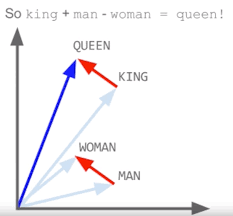

In [36]:
Image('/Users/amy/00_Springboard/14_Capstone_Project_2/king.png')

In [41]:
# tokenize train reviews & encode train labels
tokenized_train = [nltk.word_tokenize(text)
                       for text in text_reviews]

In [42]:
word2vec = gensim.models.Word2Vec(tokenized_train,
                                  size=100,
                                  window=5,
                                  min_count=1)

In [43]:
# vocab size
words = list(word2vec.wv.vocab)
print('Vocabulary size: %d' % len(words))

Vocabulary size: 16476


In [49]:
similar_words = {search_term: [item[0] for item in word2vec.wv.most_similar([search_term], topn=5)]
                  for search_term in ['pencil', 'tv', 'pen', 'cartridge', 'computer', 'ink']}
similar_words

{'pencil': ['graph', 'broad', 'triangle', 'worksheet', 'relevant'],
 'tv': ['power', 'laptop', 'hide', 'behind', 'ethernet'],
 'pen': ['write', 'energel', 'gel', 'color', 'ink'],
 'cartridge': ['refill', 'filling', 'jet', 'hp', 'toner'],
 'computer': ['power', 'usb', 'xlr', 'tv', 'behind'],
 'ink': ['printer', 'print', 'vivamart', 'cartridge', 'jet']}

In [52]:
# let us try some utility functions of gensim word2vec more details here 

word2vec.wv.most_similar('printer', topn =5)

[('print', 0.9659484624862671),
 ('jet', 0.9583272933959961),
 ('inkjet', 0.956078052520752),
 ('ink', 0.9512560367584229),
 ('laser', 0.9399692416191101)]

In [55]:
word2vec.wv.similar_by_word("paper", topn =6)

[('print', 0.9434133768081665),
 ('artisan', 0.9378037452697754),
 ('color', 0.9282441139221191),
 ('archival', 0.9200995564460754),
 ('bright', 0.918768584728241),
 ('white', 0.9171503186225891)]

In [56]:
print(word2vec.wv.similarity('laptop', 'computer'))

0.98210174


In [57]:
print(word2vec.wv.similarity('computer', 'great'))
print(word2vec.wv.similarity('tv', 'great'))
print(word2vec.wv.similarity('laptop', 'great'))
print(word2vec.wv.similarity('pen', 'great'))

0.59867984
0.6353326
0.6536818
0.5885938


In [58]:
#Let’s see the result of semantically reasonable word vectors (king - man + woman)
#Vord vectors (book - pencil + computer)
word2vec.wv.most_similar_cosmul(positive=['book', 'computer'], negative=['pencil'])

[('desk', 0.9959823489189148),
 ('diabetic', 0.9912034869194031),
 ('laptop', 0.9902352690696716),
 ('goodie', 0.9883034229278564),
 ('bag', 0.9847408533096313),
 ('carry', 0.9843491315841675),
 ('ps3', 0.9842806458473206),
 ('snugly', 0.9837926030158997),
 ('turtle', 0.9835797548294067),
 ('cupboard', 0.9833742380142212)]

In [60]:
#odd word out
print(word2vec.wv.doesnt_match('pen pencil cable book'.split()))

cable


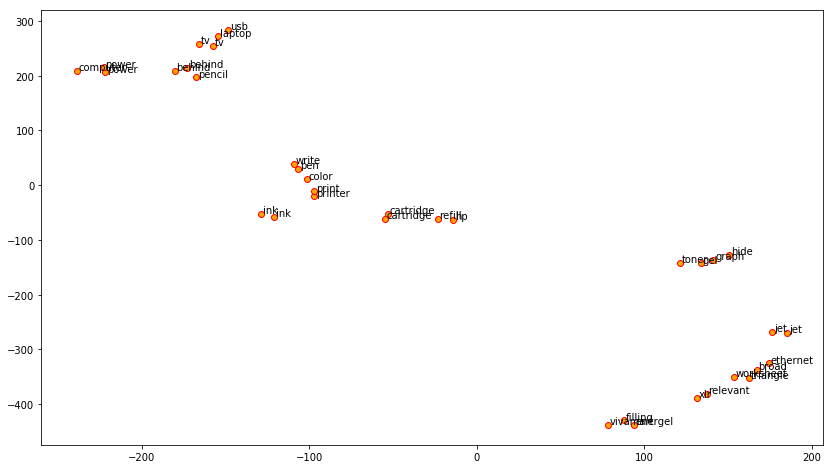

In [61]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = word2vec.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, yt in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, yt+1), xytext=(0, 0), textcoords='offset points')